# Activation Functions

In [11]:
# standard libs
import os
import json
import math
from typing import Any, Sequence
import pickle
from copy import deepcopy

import numpy as np

# imports for plotting
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")
import seaborn as sns

sns.set_theme()

# progress bar
from tqdm.auto import tqdm

# jax
import jax
import jax.numpy as jnp
from jax import random
from jax import Array  # For typehint
from jax.typing import ArrayLike  # For typehint
import flax
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax


In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial3_jax"

# Verifying the device that will be used throughout this notebook
print("Device:", jax.devices()[0])

Device: cuda:0


In [ ]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial3/"
# Files to download
pretrained_files = [
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please contact the author with the full output including the following error:\n",
                e,
            )

## Common activation functions


In [ ]:
class Sigmoid(nn.Module):
    def __call__(self, x):
        return 1 / (1 + jnp.exp(-x))


class Tanh(nn.Module):
    def __call__(self, x):
        x_exp, neg_x_exp = jnp.exp(x), jnp.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [6]:
class ReLU(nn.Module):
    def __call__(self, x):
        return jnp.maximum(x, 0)


class LeakyReLU(nn.Module):
    alpha: float = 0.1

    def __call__(self, x):
        return jnp.where(x > 0, x, self.alpha * x)


class ELU(nn.Module):
    def __call__(self, x):
        return jnp.where(x > 0, x, jnp.exp(x) - 1)


class Swish(nn.Module):
    def __call__(self, x):
        return x * nn.sigmoid(x)

In [ ]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
}

However, note that we want to take the gradients for multiple inputs independently and the gradient transformation requires the output of the forward pass to be a single scalar. We can implement this by simply summing the outputs of the activation function, since a sum distributes the gradients equally to all its inputs.

In [8]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An module or function of the forward pass of the activation function.
        x - 1D input array.
    Output:
        An array with the same size of x containing the gradients of act_fn at x.
    """
    return jax.vmap(jax.grad(act_fn))(x)

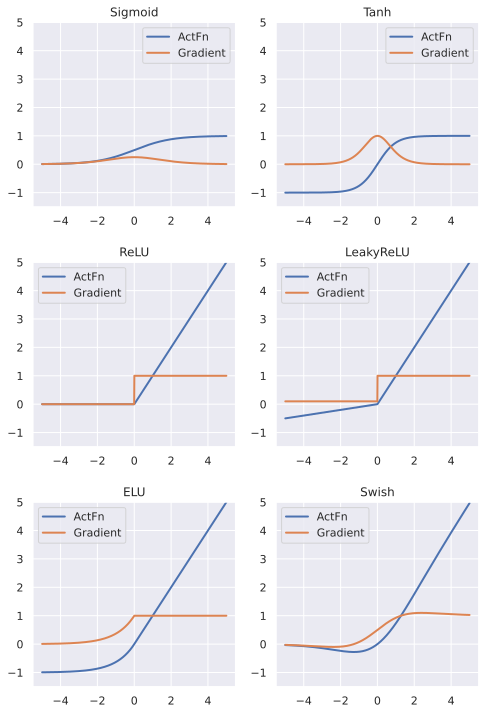

In [9]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    # x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.__class__.__name__)
    ax.legend()
    ax.set_ylim(-1.5, x.max())


# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = np.linspace(
    -5, 5, 1000
)  # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns) / 2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, 2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

## Analysing the effect of activation functions


In [12]:
def init_func(x):
    rng, shape, dtype = x
    return random.uniform(
        rng,
        shape=shape,
        minval=-1 / np.sqrt(x.shape[1]),
        maxval=1 / np.sqrt(x.shape[1]),
        dtype=dtype,
    )


# Network: a simple neural network trained on FashionMNIST
class BaseNetwork(nn.Module):
    act_fn: nn.Module  # Activation function
    num_classes: int = 10
    hidden_sizes: Sequence = (512, 256, 256, 128)

    @nn.compact
    def __call__(self, x: ArrayLike, return_activations=False):
        x = x.reshape(x.shape[0], -1)  # Reshape images to a flat vector
        # We collect all activations throughout the network for later visualizations
        # Remember that in jitted functions, unused tensors will anyways be removed.
        activations = []
        for hd in self.hidden_sizes:
            x = nn.Dense(features=hd, kernel_init=init_func(x), bias_init=init_func(x))(
                x
            )
            activations.append(x)
            x = self.act_fn(x)
            activations.append(x)
        x = nn.Dense(
            features=self.num_classes, kernel_init=init_func(x), bias_init=init_func(x)
        )(x)
        return x if not return_activations else (x, activations)

In [ ]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")


def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")


def _load_model(model_path, model_name, state=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        state - (Optional) If given, the parameters are loaded into this training state. Otherwise,
                a new one is created alongside a network architecture.
    """
    config_file, model_file = (
        _get_config_file(model_path, model_name),
        _get_model_file(model_path, model_name),
    )
    assert os.path.isfile(
        config_file
    ), f'Could not find the config file "{config_file}". Are you sure this is the correct path and you have your model config stored here?'
    assert os.path.isfile(
        model_file
    ), f'Could not find the model file "{model_file}". Are you sure this is the correct path and you have your model stored here?'
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if state is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
        state = train_state.TrainState(
            step=0, params=None, apply_fn=net.apply, tx=None, opt_state=None
        )
    else:
        net = None
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead load the parameters simply from a pickle file.
    with open(model_file, "rb") as f:
        params = pickle.load(f)
    state = state.replace(params=params)
    return state, net


def save_model(model, params, model_path, model_name):
    """
    Given a model, we save the parameters and hyperparameters.

    Inputs:
        model - Network object without parameters
        params - Parameters to save of the model
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = {
        "num_classes": model.num_classes,
        "hidden_sizes": model.hidden_sizes,
        "act_fn": {"name": model.act_fn.__class__.__name__.lower()},
    }
    if hasattr(model.act_fn, "alpha"):
        config_dict["act_fn"]["alpha"] = model.act_fn.alpha
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = (
        _get_config_file(model_path, model_name),
        _get_model_file(model_path, model_name),
    )
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead save the parameters simply in a pickle file.
    with open(model_file, "wb") as f:
        pickle.dump(params, f)


In [13]:
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms


# Transformations applied on each image => bring them into a numpy array and normalize between -1 and 1
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255.0 - 0.5) / 0.5
    return img


# We need to stack the batch elements as numpy arrays
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(
    root=DATASET_PATH, train=True, transform=image_to_numpy, download=True
)
train_set, val_set = torch.utils.data.random_split(
    train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(42)
)

# Loading the test set
test_set = FashionMNIST(
    root=DATASET_PATH, train=False, transform=image_to_numpy, download=True
)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(
    train_set, batch_size=1024, shuffle=False, drop_last=False, collate_fn=numpy_collate
)
val_loader = data.DataLoader(
    val_set, batch_size=1024, shuffle=False, drop_last=False, collate_fn=numpy_collate
)
test_loader = data.DataLoader(
    test_set, batch_size=1024, shuffle=False, drop_last=False, collate_fn=numpy_collate
)

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.57MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 100kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:04<00:00, 1.01MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



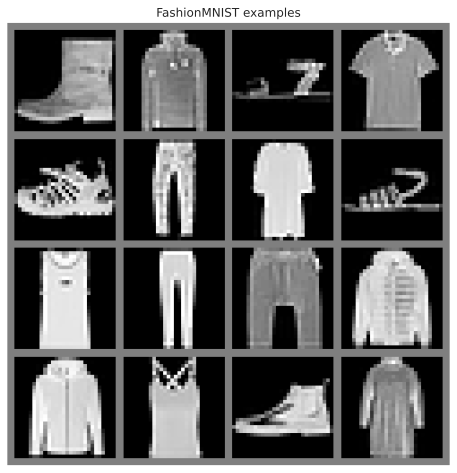

In [ ]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(
    torch.from_numpy(np.stack(exmp_imgs, axis=0))[:, None],
    nrow=4,
    normalize=True,
    pad_value=0.5,
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Visualizing the gradient flow after initialization

As mentioned previously, one important aspect of activation functions is how they propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is (in expectation) considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode.



In [15]:
small_loader = data.DataLoader(
    train_set, batch_size=256, shuffle=False, collate_fn=numpy_collate
)
exmp_batch = next(iter(small_loader))

In [16]:
def visualize_gradients(net, params, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """

    # Pass one batch through the network, and calculate the gradients for the weights
    def loss_func(p):
        imgs, labels = exmp_batch
        logits = net.apply(p, imgs)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        return loss

    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
    fig_index = 0
    for g_idx, g in enumerate(grads):
        key = f"Layer {g_idx * 2} - weights"
        key_ax = ax[g_idx % columns]
        sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
    fig.suptitle(
        f"Gradient magnitude distribution for activation function {net.act_fn.__class__.__name__}",
        fontsize=14,
        y=1.05,
    )
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

In [19]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    params = net_actfn.init(random.PRNGKey(0), exmp_batch[0])
    visualize_gradients(net_actfn, params, color=f"C{i}")

ValueError: too many values to unpack (expected 3)